In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import random
import sys
import warnings
import numpy as np
import pandas as pd
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
import cv2
import imgaug as ia
import imgaug.augmenters as iaa
from utils import *


# Setting seed for reproducability
seed = 42
#random.seed = seed
#np.random.seed = seed
os.environ["CUDA_VISIBLE_DEVICES"] = "1"



import torch
import torchvision
from torch.autograd import Variable
import torch.optim as optim
import torchvision.transforms as transforms
from multiprocessing import cpu_count

In [2]:
import torch

import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image


class CustomDataset(Dataset):
    def __init__(self, x_data, y_data, transform_img=None, transform_mask=None):
        #self.x_path = x_path
        #self.y_path = y_path
        self.transform_img = transform_img
        self.transform_mask = transform_mask

        self.data = np.transpose(x_data, (0, 3, 1, 2))
        self.targets = np.transpose(y_data, (0, 3, 1, 2))
        #self.targets = y_path

        #print(self.data.shape)
        #print(self.targets.shape)

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        
        
        if self.transform_img:
            
            seed = np.random.randint(2147483647)
            random.seed(seed)
            
            x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1, 2, 0))
            x = self.transform_img(x)
            
            random.seed(seed)
            
            y = Image.fromarray(np.squeeze(self.targets[index].astype(np.uint8).transpose(1, 2, 0)))
            y = self.transform_mask(y)
            

        return x, y


In [3]:
IMG_WIDTH=288
IMG_HEIGHT=288

In [4]:
train_img,b,c,train_mask = read_train_data_path('../data_store/train_watermark_removed.npz')
valid_img_int,b,c,valid_mask = read_test_data_path('../data_store/valid_watermark_removed.npz')

train_mask_int = (train_mask > 0.5).astype(np.uint8)
train_mask_int = (train_mask_int * 255.).astype(np.uint8)

valid_mask_int = (valid_mask > 0.5).astype(np.uint8)
valid_mask_int = (valid_mask_int * 255.).astype(np.uint8)

In [5]:
x_train = copy.deepcopy(train_img)
y_train = copy.deepcopy(train_mask_int)

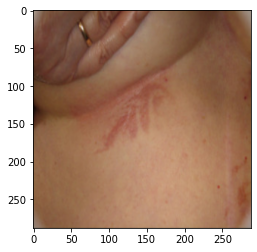

In [6]:
plt.imshow(x_train[0])

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
torch.cuda.is_available()

True

In [9]:
transform_train = transforms.Compose([
    transforms.RandomAffine(degrees=[-180,180], translate=[0.05,0.10], scale=[0.95,1.05], shear=3),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(brightness=[0.5,1.3], contrast=[0.5,1.3], saturation=0, hue=0),], p=1),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    #transforms.RandomErasing(scale=[0.02, 0.03], ratio=[0.05,0.1], p=1),
])

transform_train2 = transforms.Compose([
    transforms.RandomAffine(degrees=[-180,180], translate=[0.05,0.10], scale=[0.95,1.05], shear=3),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),    
    transforms.ToTensor(),
])



transform_test = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_test2 = transforms.Compose([
    transforms.ToTensor(),
])



In [10]:
cm_train_x, cm_train_y = get_cutmix(x_train, y_train)
cm_train_x, cm_train_y = get_cutmix(cm_train_x, cm_train_y)

#train_img_int = np.concatenate((x_train, cm_train_x), 0)
#train_mask_int = np.concatenate((y_train, cm_train_y), 0)

train_img_int = cm_train_x
train_mask_int = cm_train_y



In [11]:
x_train2 = copy.deepcopy((train_img_int / 255.).astype(np.float32))
y_train2 = copy.deepcopy((train_mask_int / 255.).astype(np.float32))

eraser = get_random_brightness_changer()

for rep in range(2):
    for i in  range(len(x_train2)):
        x_train2[i] = eraser((train_img_int[i] / 255.).astype(np.float32))
        if(i % 100 == 0):
            print(i)
        
x_train2=np.nan_to_num(x_train2, nan=0.0)
np.clip(x_train2, 0, 1, out=x_train2)

x_train2 = (x_train2*255.).astype(np.uint8)
y_train2 = (y_train2*255.).astype(np.uint8)


0
100
0
100


In [12]:
train_set = CustomDataset(x_train2, y_train2, transform_img=transform_train, transform_mask=transform_train2)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=False, num_workers=0)

In [13]:
test_set = CustomDataset(valid_img_int, valid_mask_int, transform_img=transform_test, transform_mask=transform_test2)
testloader = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=False, num_workers=0)

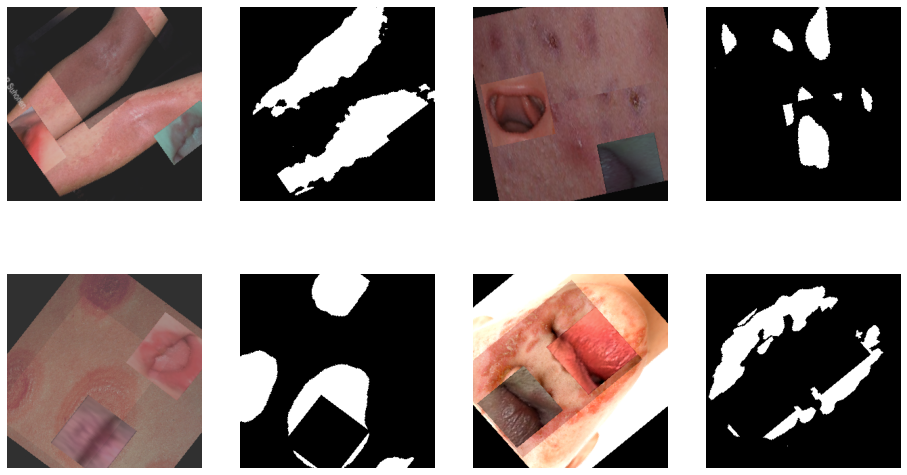

In [28]:
counter = 0
to_skip = [0, 1]

for x, y in trainloader:
    
    counter+=1
    if counter in to_skip:
        continue
    
    x = np.transpose(x, (0, 2, 3, 1))
    y = np.transpose(y, (0, 2, 3, 1))

    f, axarr = plt.subplots(2,4, figsize=(16,9))
    
    count=0
    for i in range(2):
        for j in range(2):
            

            axarr[i][0].imshow(x[i*2 + j])
            axarr[i][0].axis('off')

            axarr[i][1].imshow(np.squeeze(y[i*2 + j]), cmap='gray')
            axarr[i][1].axis('off')
            
            axarr[i][2].imshow(x[i*2 + j+1], cmap='gray')
            axarr[i][2].axis('off')
            
            axarr[i][3].imshow(np.squeeze(y[i*2 + j+1]), cmap='gray')
            axarr[i][3].axis('off')            

    plt.show()

    
    
    break

In [45]:
import segmentation_models_pytorch as smp

model = smp.Unet('resnet50', classes=1, activation='sigmoid', encoder_weights='imagenet').to(device)

In [46]:
learning_rate = 0.0005
num_epochs = 500
criterion = torch.nn.BCELoss()

In [47]:
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate,
                      #momentum=0.9, 
                             weight_decay=5e-4
                            )

In [48]:
train_total = len(train_set)
train_batches = len(trainloader)

test_baches = len(testloader)

In [49]:
# Variables for lr scheduling and early stopping

patience = 0    # Bad epoch counter
best_loss = 1024
#~Define lr, loss, epochs, optimizers, etc.

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.1, patience=20, verbose=True, min_lr=0.00000001,)

In [50]:
path_checkpoint = './models/cut2_randbrigh.pth'

In [51]:
count = 0
for epoch in range(num_epochs):
    # Train
    
    cm_train_x, cm_train_y = get_cutmix(x_train, y_train)
    cm_train_x, cm_train_y = get_cutmix(cm_train_x, cm_train_y)

    train_img_int = np.concatenate((x_train, cm_train_x), 0)
    train_mask_int = np.concatenate((y_train, cm_train_y), 0)
    
    
    x_train2 = copy.deepcopy((train_img_int / 255.).astype(np.float32))
    y_train2 = copy.deepcopy((train_mask_int / 255.).astype(np.float32))

    eraser = get_random_brightness_changer()

    for rep in range(2):
        for i in  range(len(x_train2)):
            x_train2[i] = eraser((train_img_int[i] / 255.).astype(np.float32))
            #if(i % 100 == 0):
                #print(i)

    x_train2=np.nan_to_num(x_train2, nan=0.0)
    np.clip(x_train2, 0, 1, out=x_train2)

    x_train2 = (x_train2*255.).astype(np.uint8)
    y_train2 = (y_train2*255.).astype(np.uint8)
    
    

    train_set = CustomDataset(x_train2, y_train2, transform_img=transform_train, transform_mask=transform_train2)
    trainloader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True, num_workers=0)
    
    model.train()

    train_loss = 0
    train_correct = 0

    for x, y in trainloader:
        x = x.to(device)
        y = y.to(device)

        outputs = model(x)
        loss = criterion(outputs, y)

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()


        train_loss += loss.item()
        _, predicted = outputs.max(1)
        #train_correct += predicted.eq(y).sum().item() /(288*288 * train_batches)

    train_loss = train_loss / train_batches
    #train_acc = train_correct / (train_batches)

    scheduler.step(1.)


    print('[%2d / %d] TRAIN loss: %.3f ' % (epoch+1, num_epochs , train_loss, 
                                                       #train_acc 
                                                      ), end = ' '
         )
    
    
    
    model.eval()
    
    
    

    ### test acc ###
    test_loss = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            #correct += (predicted == labels).sum().item()
            
        test_loss = test_loss / test_baches
        
        
        if(test_loss < best_loss):
            torch.save(model.state_dict(), path_checkpoint)
            best_loss = test_loss
        print('test_loss: %.3f -- Best loss: %.3f' %(test_loss, best_loss))
        

[ 1 / 500] TRAIN loss: 0.384  test_loss: 0.747 -- Best loss: 0.747
[ 2 / 500] TRAIN loss: 0.254  test_loss: 0.446 -- Best loss: 0.446
[ 3 / 500] TRAIN loss: 0.241  test_loss: 0.341 -- Best loss: 0.341
[ 4 / 500] TRAIN loss: 0.215  test_loss: 0.424 -- Best loss: 0.341
[ 5 / 500] TRAIN loss: 0.202  test_loss: 0.288 -- Best loss: 0.288
[ 6 / 500] TRAIN loss: 0.202  test_loss: 0.345 -- Best loss: 0.288
[ 7 / 500] TRAIN loss: 0.182  test_loss: 0.387 -- Best loss: 0.288
[ 8 / 500] TRAIN loss: 0.202  test_loss: 0.422 -- Best loss: 0.288
[ 9 / 500] TRAIN loss: 0.184  test_loss: 0.277 -- Best loss: 0.277
[10 / 500] TRAIN loss: 0.185  test_loss: 0.281 -- Best loss: 0.277
[11 / 500] TRAIN loss: 0.184  test_loss: 0.266 -- Best loss: 0.266
[12 / 500] TRAIN loss: 0.176  test_loss: 0.274 -- Best loss: 0.266
[13 / 500] TRAIN loss: 0.176  test_loss: 0.275 -- Best loss: 0.266
[14 / 500] TRAIN loss: 0.172  test_loss: 0.257 -- Best loss: 0.257
[15 / 500] TRAIN loss: 0.170  test_loss: 0.262 -- Best loss: 0

[239 / 500] TRAIN loss: 0.120  test_loss: 0.234 -- Best loss: 0.223
[240 / 500] TRAIN loss: 0.116  test_loss: 0.233 -- Best loss: 0.223
[241 / 500] TRAIN loss: 0.118  test_loss: 0.233 -- Best loss: 0.223
[242 / 500] TRAIN loss: 0.120  test_loss: 0.229 -- Best loss: 0.223
[243 / 500] TRAIN loss: 0.116  test_loss: 0.237 -- Best loss: 0.223
[244 / 500] TRAIN loss: 0.122  test_loss: 0.233 -- Best loss: 0.223
[245 / 500] TRAIN loss: 0.116  test_loss: 0.235 -- Best loss: 0.223
[246 / 500] TRAIN loss: 0.120  test_loss: 0.234 -- Best loss: 0.223
[247 / 500] TRAIN loss: 0.120  test_loss: 0.232 -- Best loss: 0.223
[248 / 500] TRAIN loss: 0.115  test_loss: 0.232 -- Best loss: 0.223
[249 / 500] TRAIN loss: 0.125  test_loss: 0.227 -- Best loss: 0.223
[250 / 500] TRAIN loss: 0.115  test_loss: 0.235 -- Best loss: 0.223
[251 / 500] TRAIN loss: 0.122  test_loss: 0.236 -- Best loss: 0.223
[252 / 500] TRAIN loss: 0.120  test_loss: 0.239 -- Best loss: 0.223
[253 / 500] TRAIN loss: 0.118  test_loss: 0.232 

[360 / 500] TRAIN loss: 0.122  test_loss: 0.234 -- Best loss: 0.223
[361 / 500] TRAIN loss: 0.122  test_loss: 0.237 -- Best loss: 0.223
[362 / 500] TRAIN loss: 0.118  test_loss: 0.241 -- Best loss: 0.223
[363 / 500] TRAIN loss: 0.122  test_loss: 0.239 -- Best loss: 0.223
[364 / 500] TRAIN loss: 0.120  test_loss: 0.232 -- Best loss: 0.223
[365 / 500] TRAIN loss: 0.120  test_loss: 0.231 -- Best loss: 0.223
[366 / 500] TRAIN loss: 0.117  test_loss: 0.239 -- Best loss: 0.223
[367 / 500] TRAIN loss: 0.114  test_loss: 0.233 -- Best loss: 0.223
[368 / 500] TRAIN loss: 0.120  test_loss: 0.229 -- Best loss: 0.223
[369 / 500] TRAIN loss: 0.121  test_loss: 0.232 -- Best loss: 0.223
[370 / 500] TRAIN loss: 0.116  test_loss: 0.237 -- Best loss: 0.223
[371 / 500] TRAIN loss: 0.118  test_loss: 0.237 -- Best loss: 0.223
[372 / 500] TRAIN loss: 0.119  test_loss: 0.235 -- Best loss: 0.223
[373 / 500] TRAIN loss: 0.119  test_loss: 0.234 -- Best loss: 0.223
[374 / 500] TRAIN loss: 0.118  test_loss: 0.235 

[481 / 500] TRAIN loss: 0.121  test_loss: 0.237 -- Best loss: 0.223
[482 / 500] TRAIN loss: 0.114  test_loss: 0.233 -- Best loss: 0.223
[483 / 500] TRAIN loss: 0.111  test_loss: 0.241 -- Best loss: 0.223
[484 / 500] TRAIN loss: 0.117  test_loss: 0.232 -- Best loss: 0.223
[485 / 500] TRAIN loss: 0.116  test_loss: 0.239 -- Best loss: 0.223
[486 / 500] TRAIN loss: 0.115  test_loss: 0.239 -- Best loss: 0.223
[487 / 500] TRAIN loss: 0.122  test_loss: 0.232 -- Best loss: 0.223
[488 / 500] TRAIN loss: 0.115  test_loss: 0.237 -- Best loss: 0.223
[489 / 500] TRAIN loss: 0.117  test_loss: 0.238 -- Best loss: 0.223
[490 / 500] TRAIN loss: 0.115  test_loss: 0.236 -- Best loss: 0.223
[491 / 500] TRAIN loss: 0.117  test_loss: 0.228 -- Best loss: 0.223
[492 / 500] TRAIN loss: 0.124  test_loss: 0.243 -- Best loss: 0.223
[493 / 500] TRAIN loss: 0.119  test_loss: 0.233 -- Best loss: 0.223
[494 / 500] TRAIN loss: 0.121  test_loss: 0.233 -- Best loss: 0.223
[495 / 500] TRAIN loss: 0.117  test_loss: 0.233 

In [52]:
model.load_state_dict(torch.load(path_checkpoint))

<All keys matched successfully>

In [53]:
comb_outs = []

model.eval()
test_loss = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        
        a = np.transpose(outputs.cpu(), (0,2,3,1))
        a = np.array(a)
        
        comb_outs.append(a)

In [54]:
comb_outs = np.array(comb_outs)

In [55]:
comb_outs.shape

(5, 8, 288, 288, 1)

In [56]:
comb_outs = np.reshape(comb_outs, (5*8, 288,288,1))

In [57]:
preds_test_t = (comb_outs > 0.5).astype(np.uint8)

preds_test_t2 = (comb_outs > 0.4).astype(np.uint8)

preds_test_t3 = (comb_outs > 0.3).astype(np.uint8)

preds_test_t4 = (comb_outs > 0.2).astype(np.uint8)

preds_test_t5 = (comb_outs > 0.1).astype(np.uint8)

preds_test_t6 = (comb_outs > 0.05).astype(np.uint8)

In [58]:
real = copy.deepcopy(valid_img_int[:,:,:,0:3])
print(real.shape)

copy_img = copy.deepcopy(valid_img_int[:,:,:,0:3])
copy_img2 = copy.deepcopy(valid_img_int[:,:,:,0:3])
copy_img3 = copy.deepcopy(valid_img_int[:,:,:,0:3])
copy_img4 = copy.deepcopy(valid_img_int[:,:,:,0:3])
copy_img5 = copy.deepcopy(valid_img_int[:,:,:,0:3])
copy_img6 = copy.deepcopy(valid_img_int[:,:,:,0:3])


(40, 288, 288, 3)


In [59]:
def color_imgs(copy_img, preds):
    
    #Predicted images
    for i in range(copy_img.shape[0]):
        for j in range(copy_img.shape[1]):
            for k in range(copy_img.shape[2]):
                if(preds[i][j][k] == 1):
                    copy_img[i][j][k] = [0,0,255]

    
    print('done')
    return copy_img


real = color_imgs(real, valid_mask)
copy_img = color_imgs(copy_img, preds_test_t)
copy_img2 = color_imgs(copy_img2, preds_test_t2)
copy_img3 = color_imgs(copy_img3, preds_test_t3)
copy_img4 = color_imgs(copy_img4, preds_test_t4)
copy_img5 = color_imgs(copy_img5, preds_test_t5)
copy_img6 = color_imgs(copy_img6, preds_test_t6)

done
done
done
done
done
done
done


In [60]:
#calculate confusion matrix

def sort_scores(valid_img, preds, y_test):

    a = []
    for s in range(len(valid_img)):
        tp = 0
        fp = 0
        tn = 0
        fn = 0

        for i in range(IMG_HEIGHT):
            for j in range(IMG_HEIGHT):
                if(int(preds[s][i][j]) == 0 and int(y_test[s][i][j]) == 0):
                    tn += 1

                if(int(preds[s][i][j]) == 0 and int(y_test[s][i][j]) == 1):
                    fn += 1

                if(int(preds[s][i][j]) == 1 and int(y_test[s][i][j]) == 0):
                    fp += 1

                if(int(preds[s][i][j]) == 1 and int(y_test[s][i][j]) == 1):
                    tp += 1

        a.append((tp / (tp + fn))+(tn / (tn + fp)))

    f = np.argsort(a)    
    
    return f


In [61]:
#sort by score of threshold=0.5
scores = sort_scores(copy_img, preds_test_t, valid_mask)

<ipython-input-62-24e49ff629e6>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axarr = plt.subplots(1,8, figsize=(20,20))


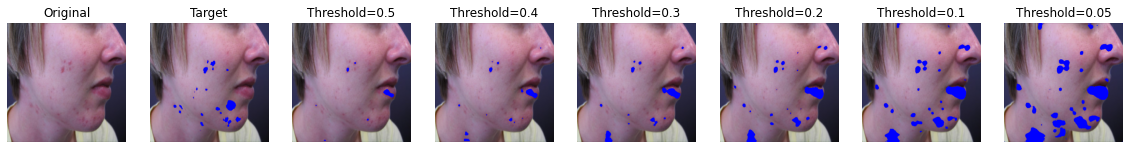

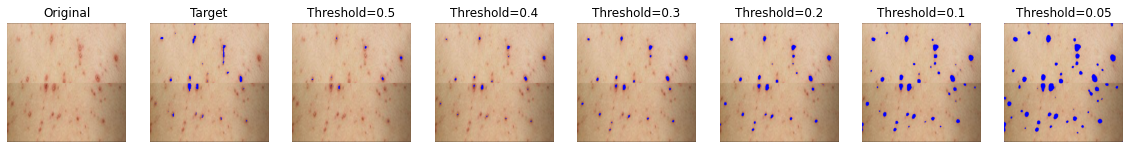

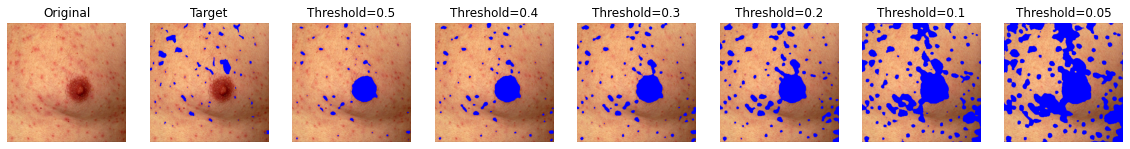

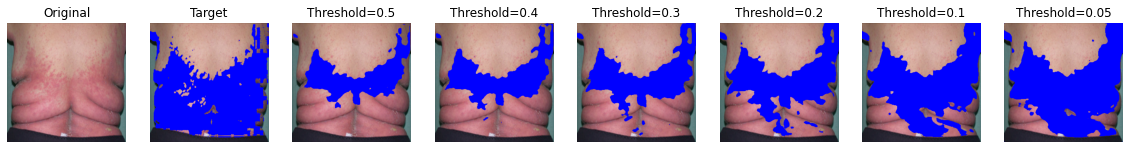

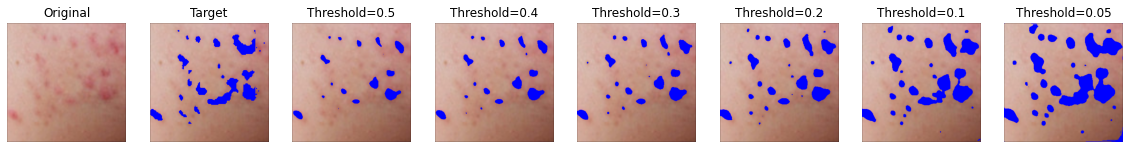

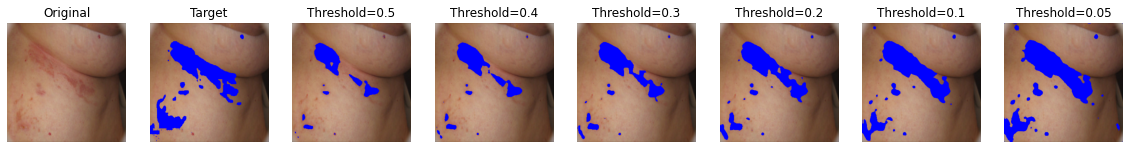

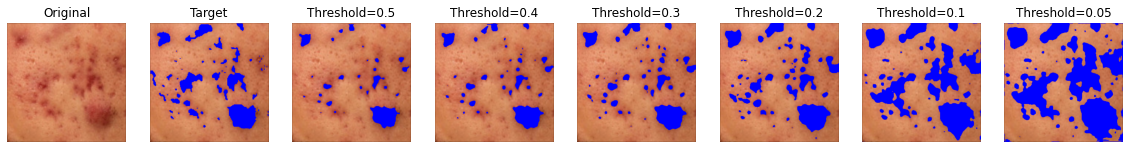

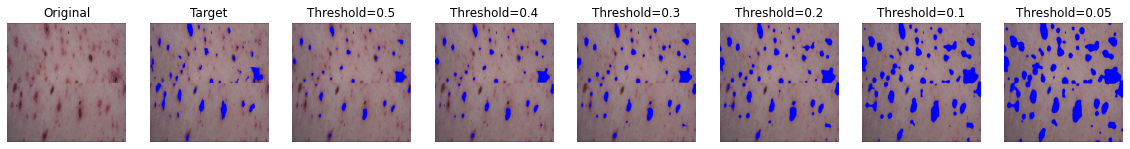

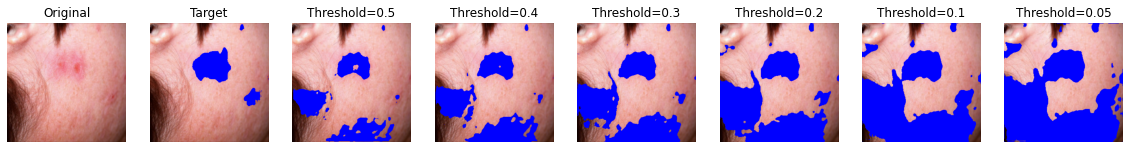

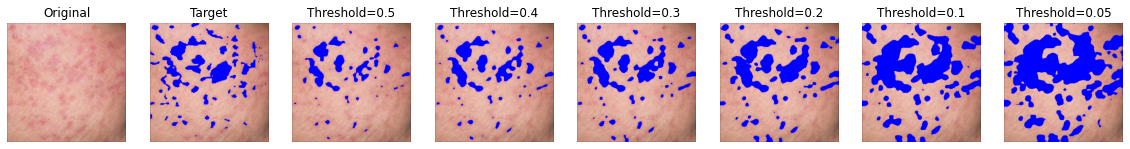

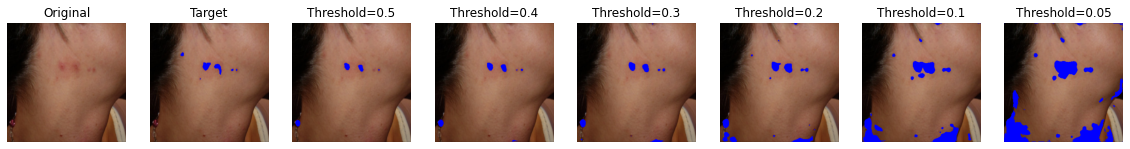

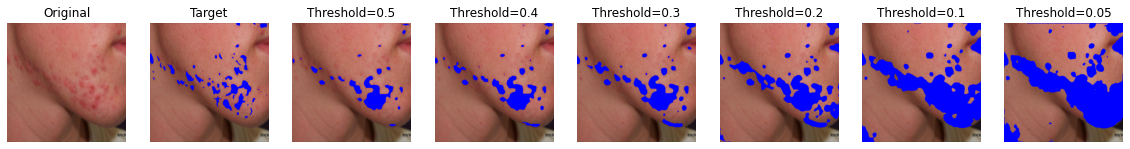

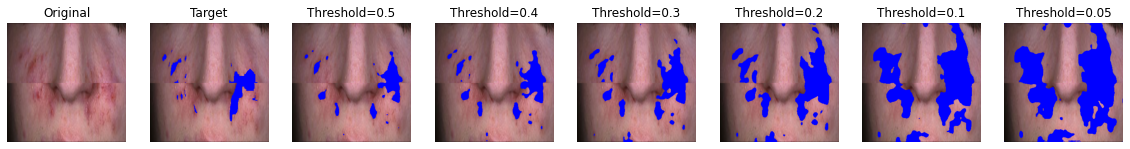

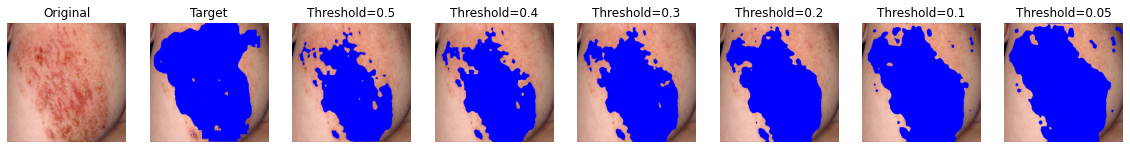

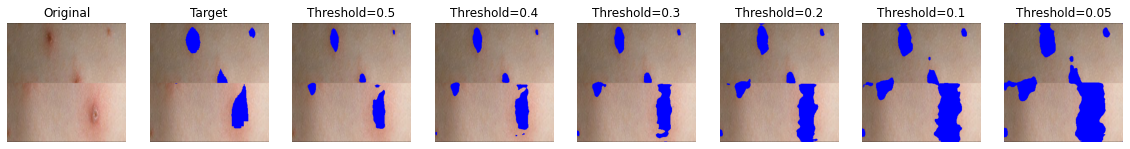

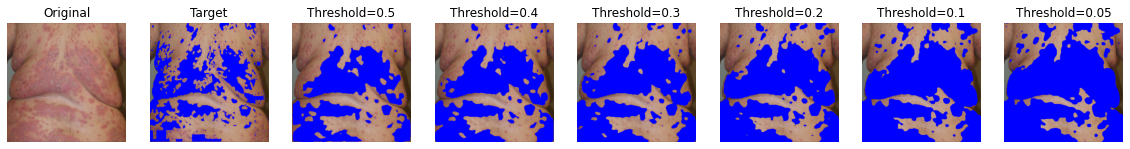

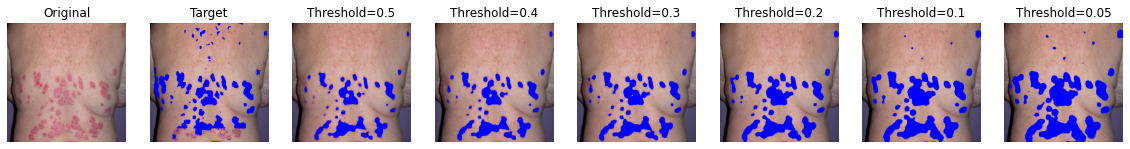

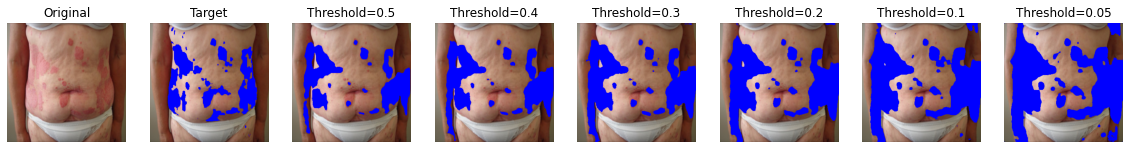

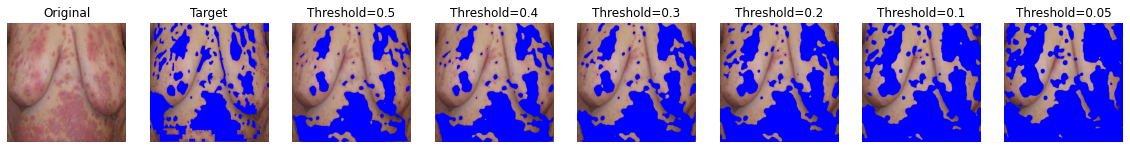

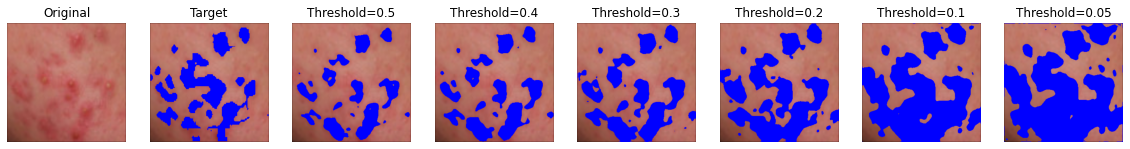

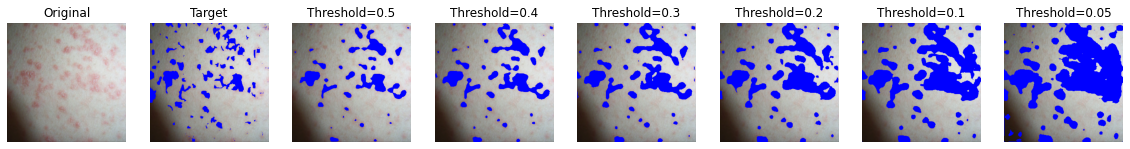

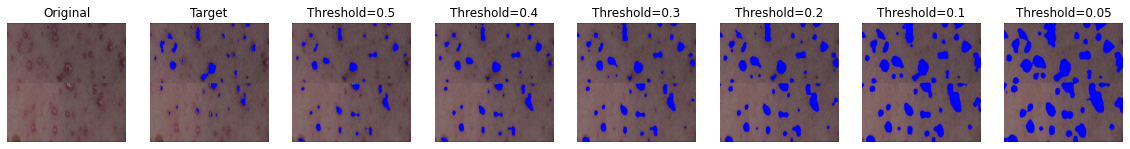

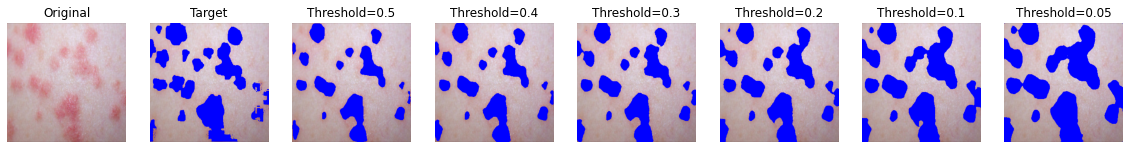

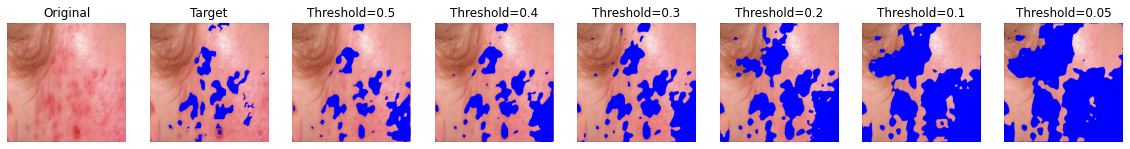

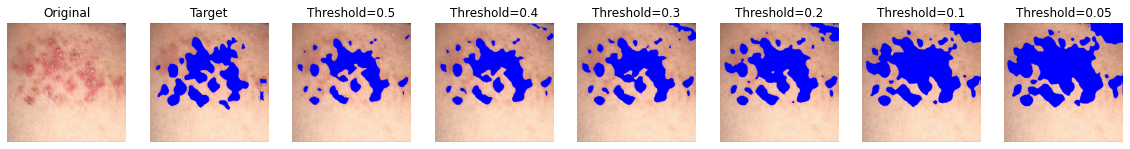

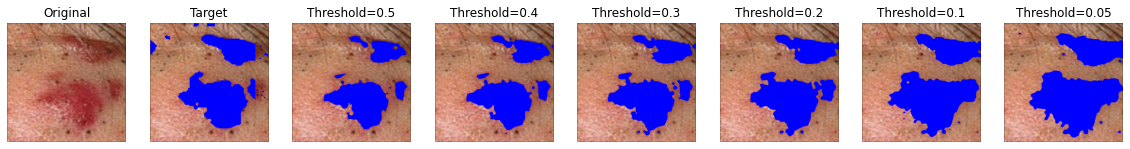

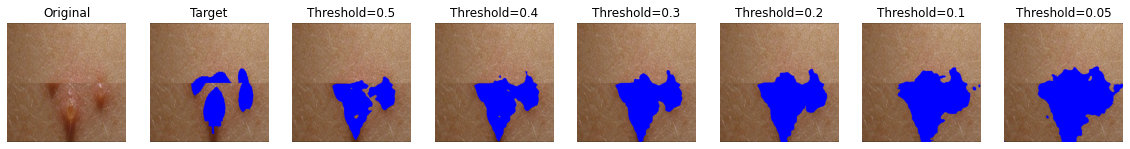

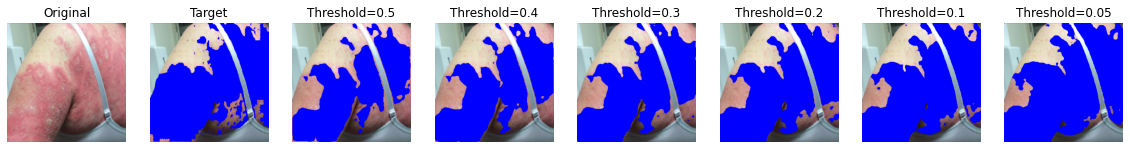

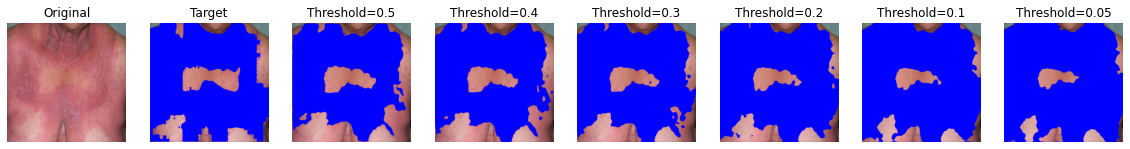

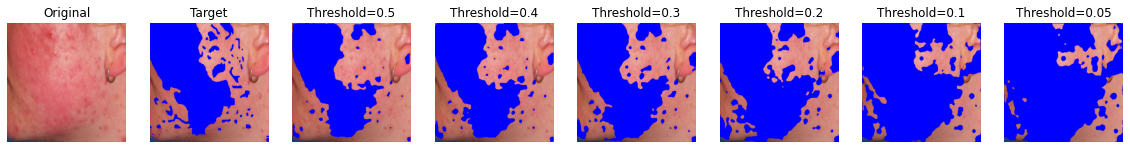

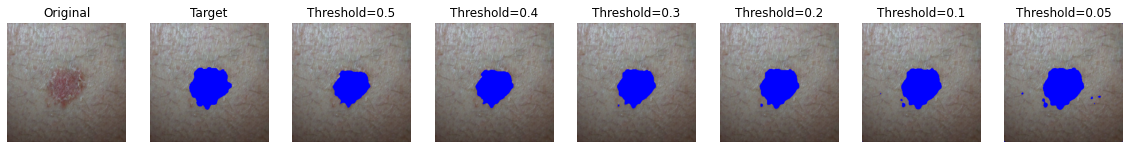

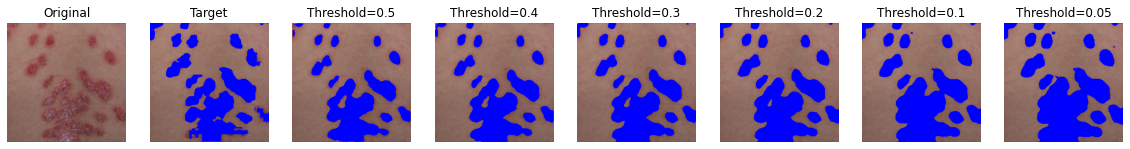

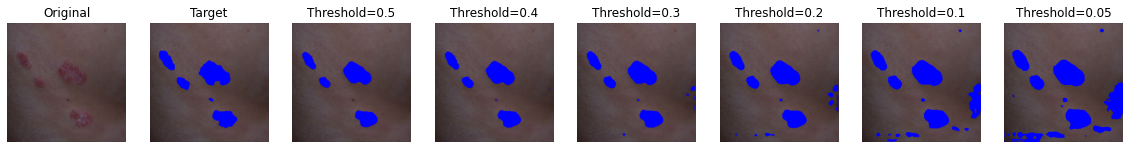

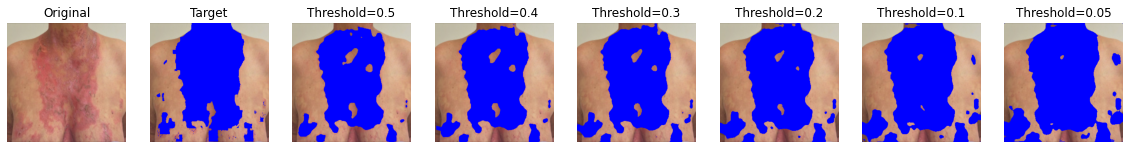

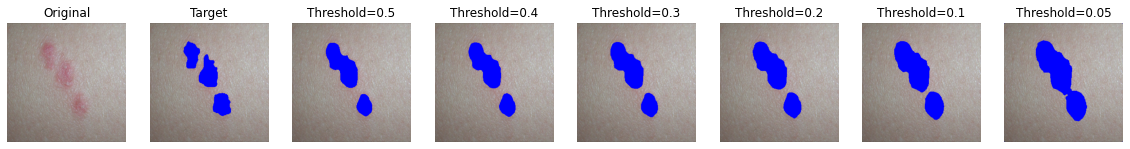

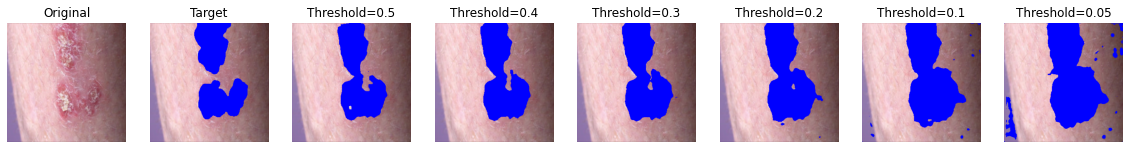

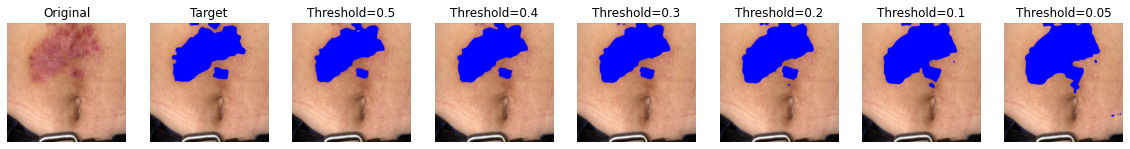

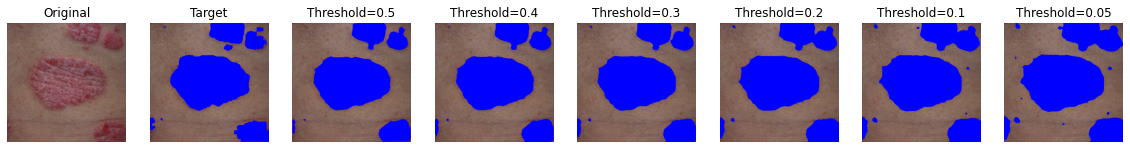

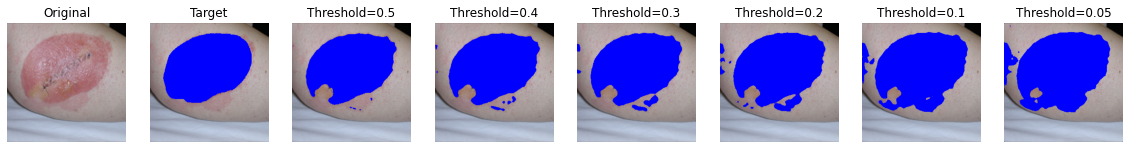

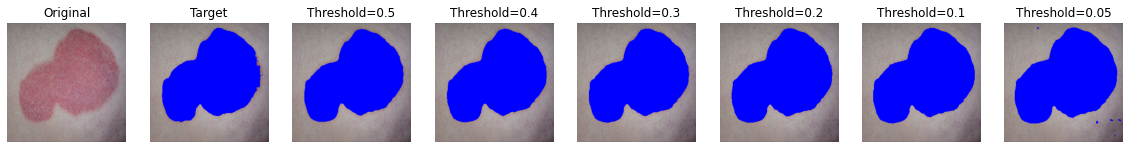

In [62]:
for i in range(len(copy_img2)):
    f, axarr = plt.subplots(1,8, figsize=(20,20))
    
    x = scores[i]
    
    axarr[0].imshow(valid_img_int[x])
    axarr[0].axis('off')
    axarr[0].set_title('Original')
    
    axarr[1].imshow(real[x])
    axarr[1].axis('off')
    axarr[1].set_title('Target')

    axarr[2].imshow(copy_img[x])
    axarr[2].axis('off')
    axarr[2].set_title('Threshold=0.5')

    axarr[3].imshow(copy_img2[x])
    axarr[3].axis('off')
    axarr[3].set_title('Threshold=0.4')

    axarr[4].imshow(copy_img3[x])
    axarr[4].axis('off')
    axarr[4].set_title('Threshold=0.3')

    axarr[5].imshow(copy_img4[x])
    axarr[5].axis('off')
    axarr[5].set_title('Threshold=0.2')

    axarr[6].imshow(copy_img5[x])
    axarr[6].axis('off')
    axarr[6].set_title('Threshold=0.1')

    axarr[7].imshow(copy_img6[x])
    axarr[7].axis('off')
    axarr[7].set_title('Threshold=0.05')
    
    #plt.cla()




In [63]:
plt.close('all')

In [64]:
#calculate confusion matrix



def get_scores(thresh):
    tp = 0
    fp = 0

    tn = 0
    fn = 0
    for s in range(len(valid_img_int)):
        for i in range(IMG_HEIGHT):
            for j in range(IMG_HEIGHT):
                if(int(thresh[s][i][j]) == 0 and int(valid_mask[s][i][j]) == 0):
                    tn += 1

                if(int(thresh[s][i][j]) == 0 and int(valid_mask[s][i][j]) == 1):
                    fn += 1

                if(int(thresh[s][i][j]) == 1 and int(valid_mask[s][i][j]) == 0):
                    fp += 1

                if(int(thresh[s][i][j]) == 1 and int(valid_mask[s][i][j]) == 1):
                    tp += 1
                    
    return (tp / (tp+fn)), (tn / (tn + fp))

In [65]:
sens1, spec1 = get_scores(preds_test_t)
print('done')

sens2, spec2 = get_scores(preds_test_t2)
print('done')

sens3, spec3 = get_scores(preds_test_t3)
print('done')

sens4, spec4 = get_scores(preds_test_t4)
print('done')

sens5, spec5 = get_scores(preds_test_t5)
print('done')

sens6, spec6 = get_scores(preds_test_t6)
print('done')



done
done
done
done
done
done


In [66]:
print("Threshold: 0.5")
print("Sensitivity: " + str(int(np.round(sens1 * 100))) + "%")
print("Specificity: " + str(int(np.round(spec1 * 100))) + "%")

print('------------------------------------------------------')

print("Threshold: 0.4")
print("Sensitivity: " + str(int(np.round(sens2 * 100))) + "%")
print("Specificity: " + str(int(np.round(spec2 * 100))) + "%")

print('------------------------------------------------------')

print("Threshold: 0.3")
print("Sensitivity: " + str(int(np.round(sens3 * 100))) + "%")
print("Specificity: " + str(int(np.round(spec3 * 100))) + "%")

print('------------------------------------------------------')

print("Threshold: 0.2")
print("Sensitivity: " + str(int(np.round(sens4 * 100))) + "%")
print("Specificity: " + str(int(np.round(spec4 * 100))) + "%")

print('------------------------------------------------------')

print("Threshold: 0.1")
print("Sensitivity: " + str(int(np.round(sens5 * 100))) + "%")
print("Specificity: " + str(int(np.round(spec5 * 100))) + "%")

print('------------------------------------------------------')

print("Threshold: 0.05")
print("Sensitivity: " + str(int(np.round(sens6 * 100))) + "%")
print("Specificity: " + str(int(np.round(spec6 * 100))) + "%")

Threshold: 0.5
Sensitivity: 72%
Specificity: 97%
------------------------------------------------------
Threshold: 0.4
Sensitivity: 76%
Specificity: 96%
------------------------------------------------------
Threshold: 0.3
Sensitivity: 81%
Specificity: 94%
------------------------------------------------------
Threshold: 0.2
Sensitivity: 87%
Specificity: 91%
------------------------------------------------------
Threshold: 0.1
Sensitivity: 92%
Specificity: 85%
------------------------------------------------------
Threshold: 0.05
Sensitivity: 95%
Specificity: 80%


In [154]:
preds_test_t7 = (comb_outs > 0.04).astype(np.uint8)
copy_img7 = copy.deepcopy(valid_img_int[:,:,:,0:3])

copy_img7 = color_imgs(copy_img7, preds_test_t7)

sens7, spec7 = get_scores(preds_test_t7)
print('done')

print("With threshold: 0.04")
print("Sensitivity: " + str(int(np.round(sens7 * 100))) + "%")
print("Specificity: " + str(int(np.round(spec7 * 100))) + "%")

done
done
With threshold: 0.04
Sensitivity: 96%
Specificity: 76%


In [158]:
crf_res = np.zeros((40, 288,288, 1), np.uint8)

for i in range(len(valid_img_int)):
    crf_res[i] = perform_crf(valid_img_int[i], preds_test_t7[i], 288, 2)

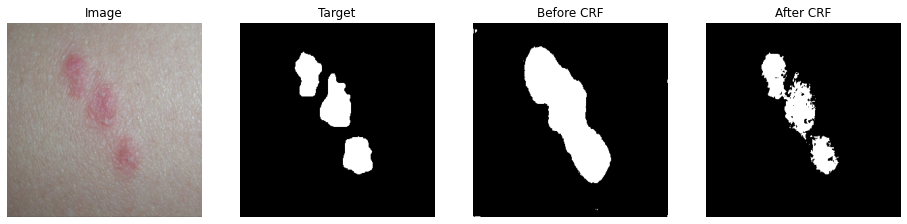

In [160]:
i = 0

f, axarr = plt.subplots(1,4, figsize=(16,16))

axarr[0].imshow(valid_img_int[i])
axarr[0].axis('off')
axarr[0].set_title('Image')

axarr[1].imshow(np.squeeze(valid_mask[i]), cmap='gray')
axarr[1].axis('off')
axarr[1].set_title('Target')

axarr[2].imshow(np.squeeze(preds_test_t7[i]), cmap='gray')
axarr[2].axis('off')
axarr[2].set_title('Before CRF')

axarr[3].imshow(np.squeeze(crf_res[i]), cmap='gray')
axarr[3].axis('off')
axarr[3].set_title('After CRF')

plt.show()

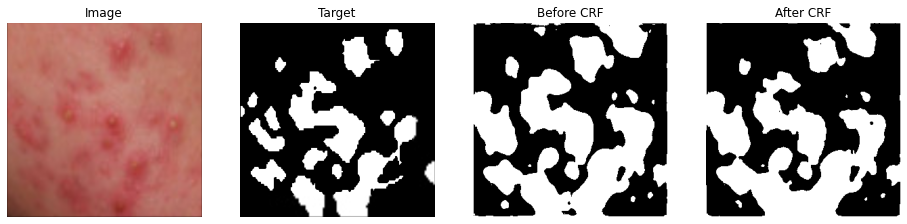

In [63]:
i = 4

f, axarr = plt.subplots(1,4, figsize=(16,16))

axarr[0].imshow(valid_img[i])
axarr[0].axis('off')
axarr[0].set_title('Image')

axarr[1].imshow(np.squeeze(valid_mask[i]), cmap='gray')
axarr[1].axis('off')
axarr[1].set_title('Target')

axarr[2].imshow(np.squeeze(preds_test_t7[i]), cmap='gray')
axarr[2].axis('off')
axarr[2].set_title('Before CRF')

axarr[3].imshow(np.squeeze(crf_res[i]), cmap='gray')
axarr[3].axis('off')
axarr[3].set_title('After CRF')

plt.show()

In [161]:
crf_img = copy.deepcopy(valid_img_int[:,:,:,0:3])

copy_crf = color_imgs(crf_img, crf_res)

done


<ipython-input-165-ed39078d6d51>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axarr = plt.subplots(1,4, figsize=(14,14))


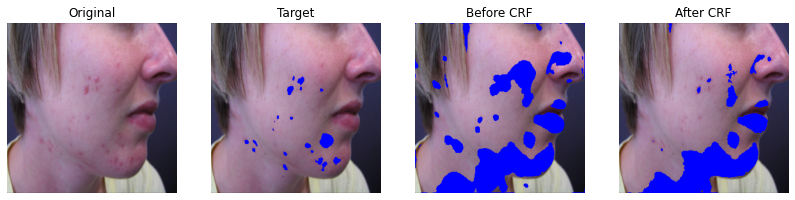

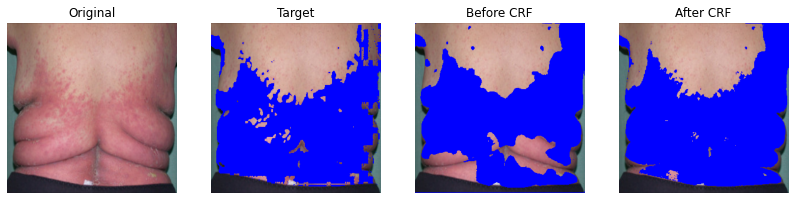

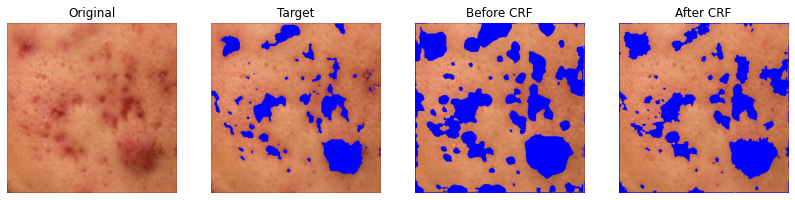

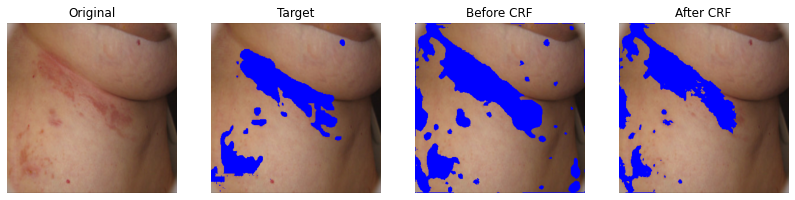

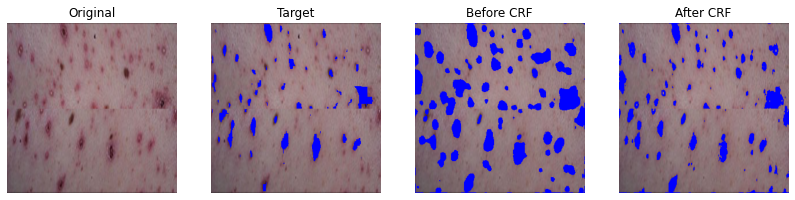

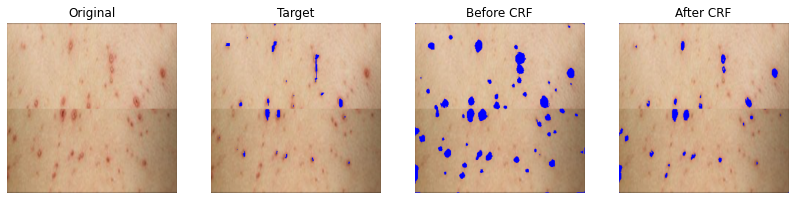

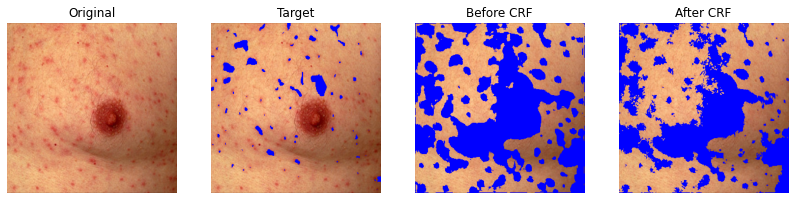

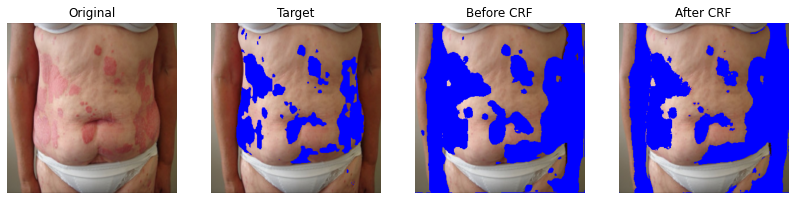

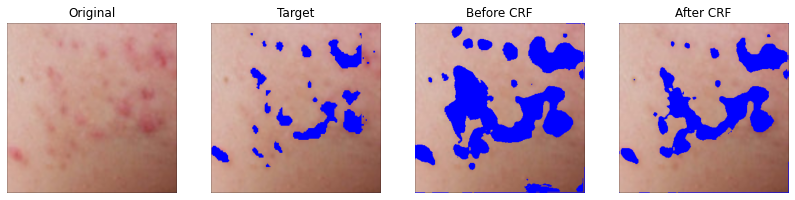

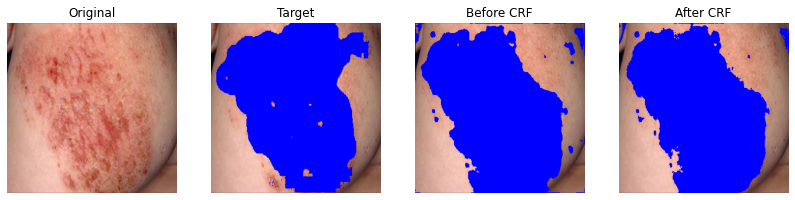

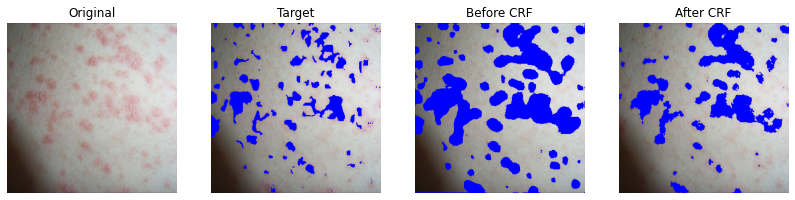

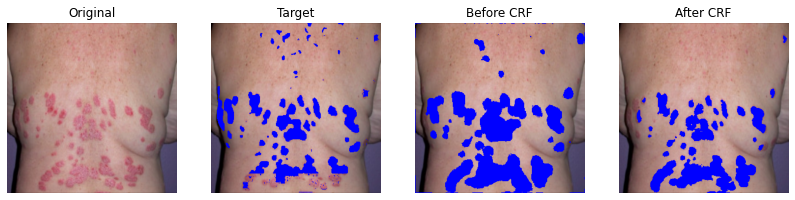

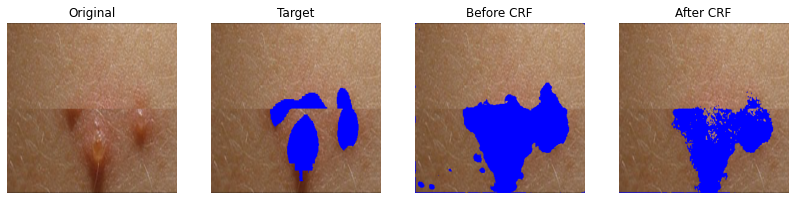

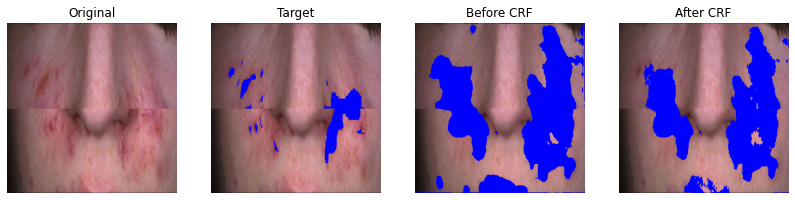

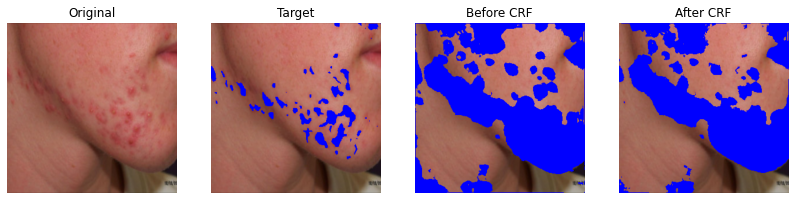

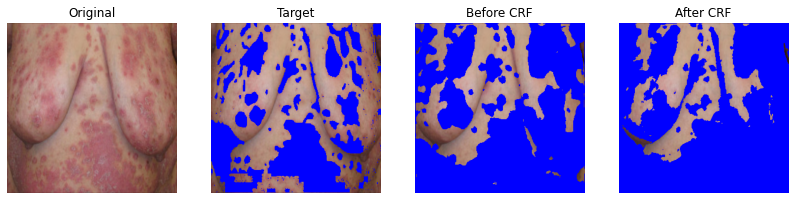

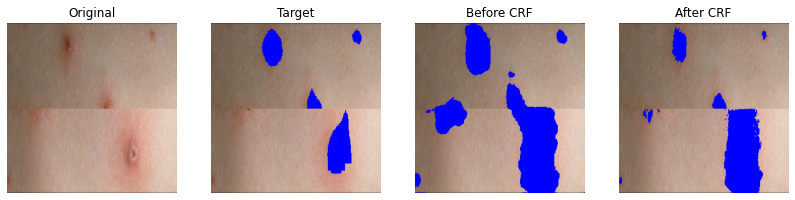

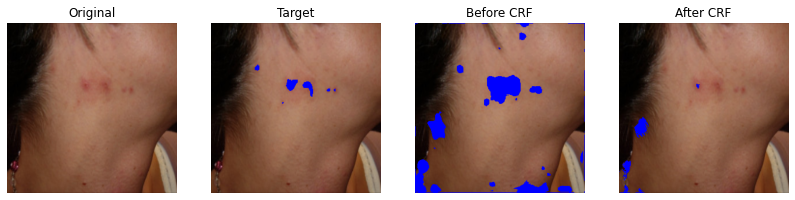

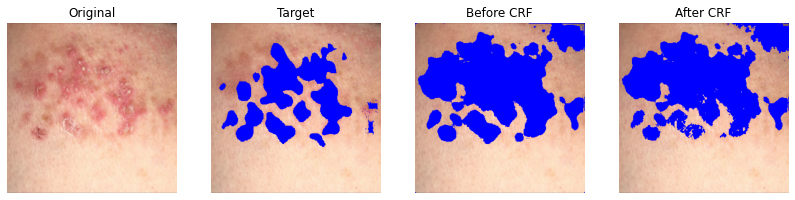

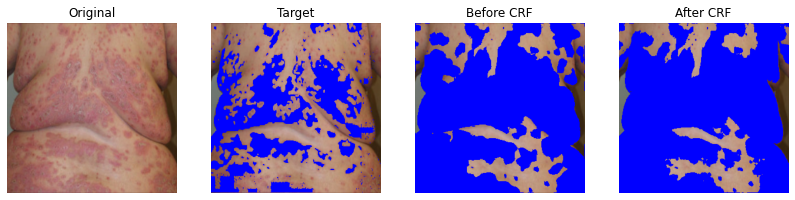

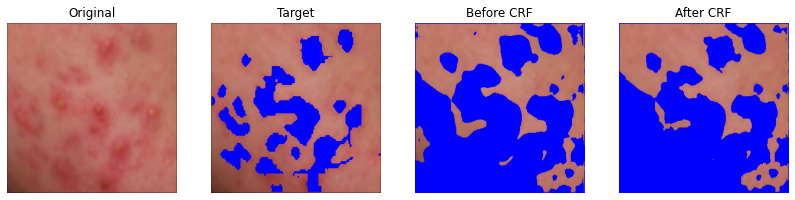

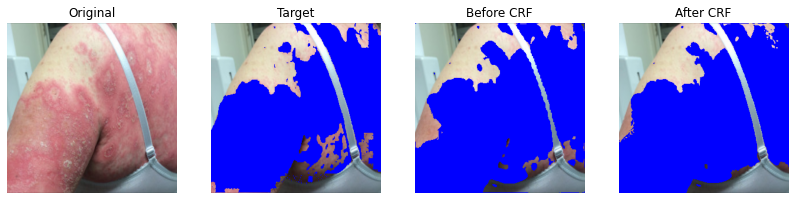

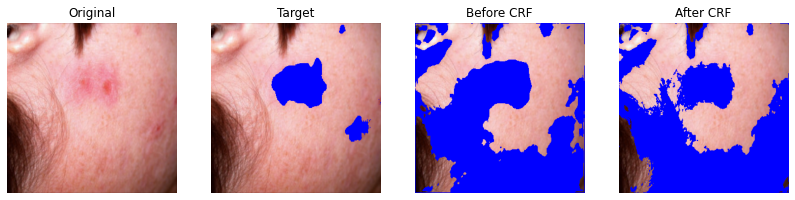

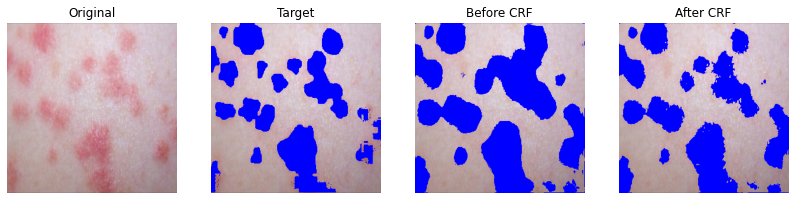

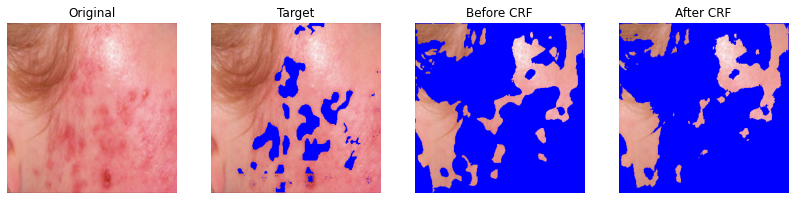

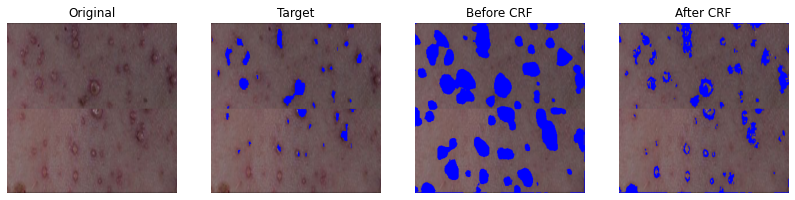

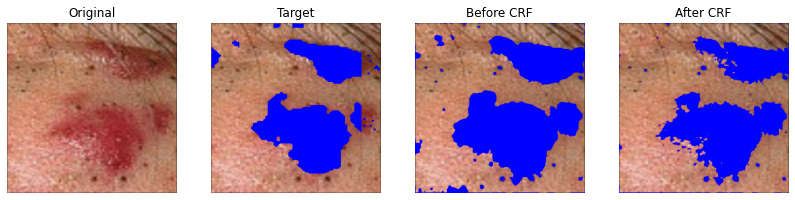

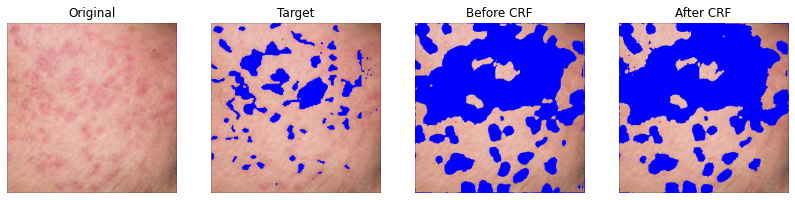

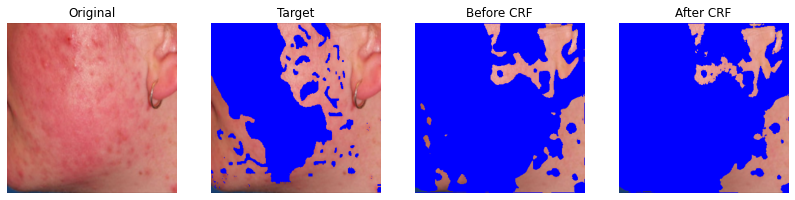

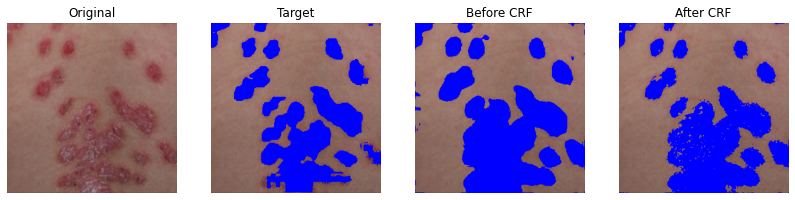

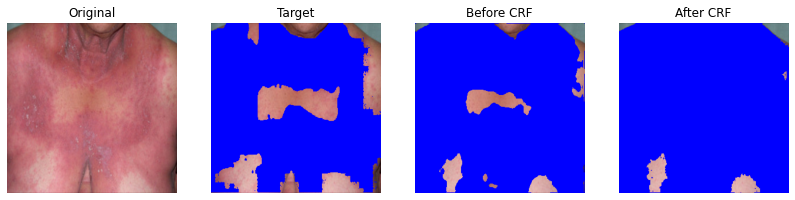

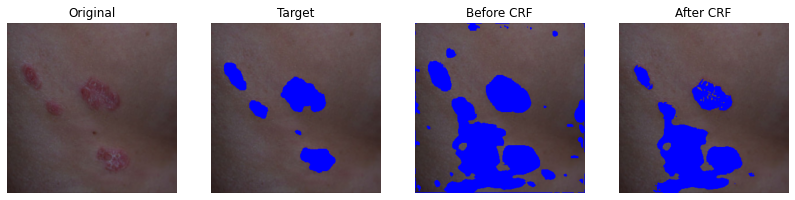

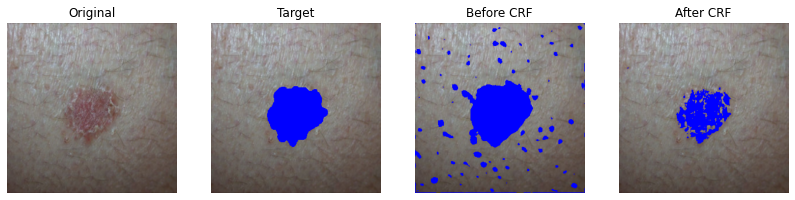

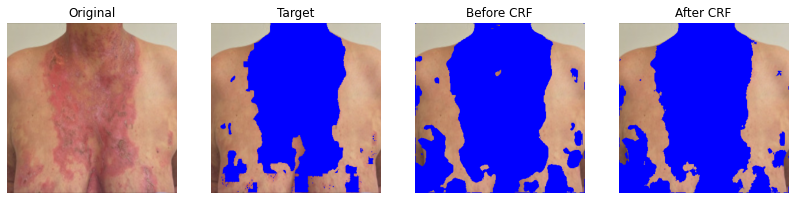

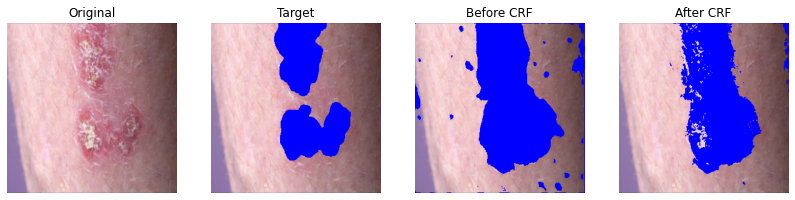

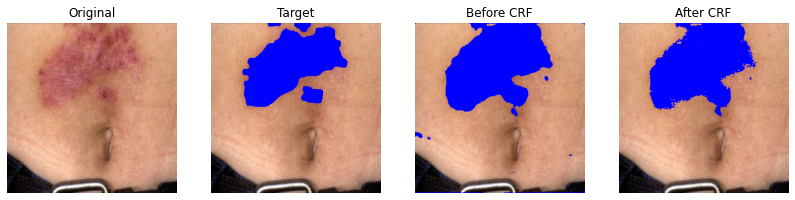

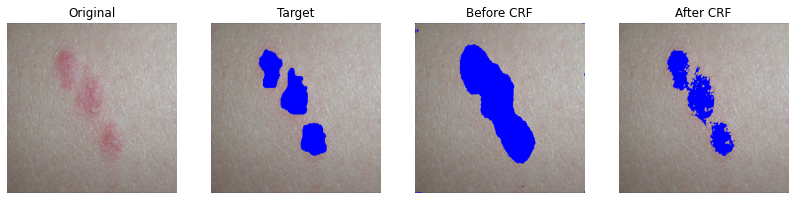

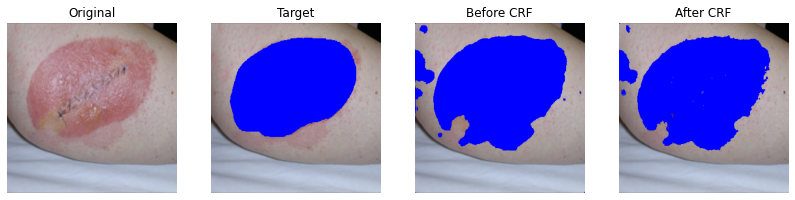

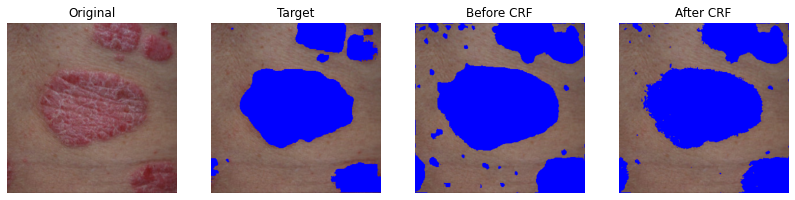

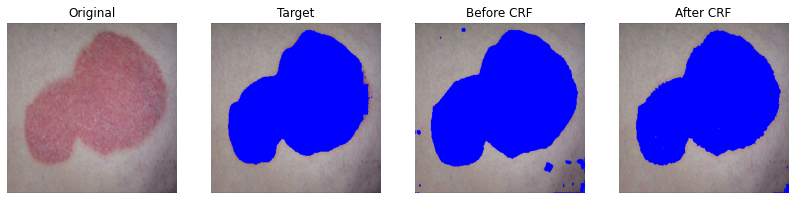

In [165]:
for i in range(len(copy_crf)):
    f, axarr = plt.subplots(1,4, figsize=(14,14))
    
    x = scores[i]
    
    axarr[0].imshow(valid_img_int[x])
    axarr[0].axis('off')
    axarr[0].set_title('Original')
    
    axarr[1].imshow(real[x])
    axarr[1].axis('off')
    axarr[1].set_title('Target')
    
    axarr[2].imshow(copy_img7[x])
    axarr[2].axis('off')
    axarr[2].set_title('Before CRF')
    
    axarr[3].imshow(copy_crf[x])
    axarr[3].axis('off')
    axarr[3].set_title('After CRF')    

In [163]:
plt.close('all')
sens8, spec8 = get_scores(crf_res)
print('done')

done


In [164]:
print("Before CRF -- Threshold: 0.04")
print("Sensitivity: " + str(int(np.round(sens7 * 100))) + "%")
print("Specificity: " + str(int(np.round(spec7 * 100))) + "%")

print('------------------------------------------------------')

print("AFTER CRF")
print("Sensitivity: " + str(int(np.round(sens8 * 100))) + "%")
print("Specificity: " + str(int(np.round(spec8 * 100))) + "%")

Before CRF -- Threshold: 0.04
Sensitivity: 96%
Specificity: 76%
------------------------------------------------------
AFTER CRF
Sensitivity: 94%
Specificity: 80%
